## Imports

In [120]:
import os
import numpy as np
import pandas as pd
import re
import time
from tqdm import tqdm 
from gensim.models import Word2Vec
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import plot_model 
from keras.callbacks import EarlyStopping, TensorBoard
import pretty_midi
import warnings
from sklearn.model_selection import train_test_split
#from plot_keras_history import show_history, plot_history
import seaborn as sns

## 1. Data Exploration and Preprocess

### 1.1. Preprocess

In [9]:
def read_lyrics_set(path):
    columns = ["artist", "song_1", "lyrics_1", "song_2", "lyrics_2", "song_3", "lyrics_3"]
    df = pd.read_csv(path, names=columns, header=None)
    
    # Create an empty DataFrame with the desired columns
    new_df = pd.DataFrame(columns=['artist', 'song', 'lyrics', 'midi_file'])

    # Iterate over the original DataFrame row by row
    for index, row in df.iterrows():
        # Extract the values from the current row
        artist = row['artist']
        song_1 = row['song_1']
        lyrics_1 = row['lyrics_1']
        
        # Add the current row to the new DataFrame
        new_df = pd.concat([new_df, pd.DataFrame({'artist': [artist], 'song': [song_1], 'lyrics': [lyrics_1]})], ignore_index=True)
        
        # Check if song_name_3 is not NaN
        if not pd.isnull(row['song_2']):
            # Extract the values from the next two rows
            song_2 = row['song_2']
            lyrics_2 = row['lyrics_2']
            new_df = pd.concat([new_df, pd.DataFrame({'artist': [artist], 'song': [song_2], 'lyrics': [lyrics_2]})], ignore_index=True)
            
            if not pd.isnull(row['song_3']):
                song_3 = row['song_3']
                lyrics_3 = row['lyrics_3']
                new_df = pd.concat([new_df, pd.DataFrame({'artist': [artist], 'song': [song_3], 'lyrics': [lyrics_3]})], ignore_index=True)
    
    new_df['song'] = new_df['song'].str.strip()
    new_df['artist'] = new_df['artist'].str.strip()
    return new_df


In [10]:
def add_midi_file_name_to_df(df, folder_path):
    # Iterate over the MIDI files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".mid"):
            # Extract the artist and song names from the file name
            artist = filename.split("_-_")[0].lower().replace("_", " ")
            song = filename.split("_-_")[1].lower().replace("_", " ").replace(".mid", "")
            # Find the matching row in the DataFrame by artist and song
            match_row = df[(df['artist'].str.lower() == artist) & (df['song'].str.lower() == song)]
            # Check if a match is found
            if not match_row.empty:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    try:
                        # Attempt to load the MIDI file
                        pretty_midi.PrettyMIDI(f"{folder_path}/{filename}")

                        # Get the index of the match row
                        match_index = match_row.index[0]

                        # Update the "midi_file" column with the original MIDI file name
                        df.at[match_index, 'midi_file'] = filename
                    except:
                        print(f"Error processing MIDI file: {filename}")

    # Remove rows with NaN or None values
    df = df.dropna()

    # Reset the index after removing rows
    df = df.reset_index(drop=True)

    return df


In [11]:
def replace_words(text):
    replacements = {
    r"\bisn't\b": "is not",
    r"\bwon't\b": "will not",
    r"\baren't\b": "are not",
    r"\bwasn't\b": "was not",
    r"\bweren't\b": "were not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bcan't\b": "cannot",
    r"\bcouldn't\b": "could not",
    r"\bshouldn't\b": "should not",
    r"\bwouldn't\b": "would not",
    r"\bmightn't\b": "might not",
    r"\bmustn't\b": "must not",
    r"\bI'm\b": "I am",
    r"\byou're\b": "you are",
    r"\bhe's\b": "he is",
    r"\bshe's\b": "she is",
    r"\bit's\b": "it is",
    r"\bwe're\b": "we are",
    r"\bthey're\b": "they are",
    r"\bi've\b": "I have",
    r"\byou've\b": "you have",
    r"\bwe've\b": "we have",
    r"\bthey've\b": "they have",
    r"\bi'd\b": "I would",
    r"\byou'd\b": "you would",
    r"\bhe'd\b": "he would",
    r"\bshe'd\b": "she would",
    r"\bit'd\b": "it would",
    r"\bwe'd\b": "we would",
    r"\bthey'd\b": "they would",
    r"\bi'll\b": "I will",
    r"\byou'll\b": "you will",
    r"\bhe'll\b": "he will",
    r"\bshe'll\b": "she will",
    r"\bit'll\b": "it will",
    r"\bwe'll\b": "we will",
    r"\bthey'll\b": "they will",
}

    # Apply the replacements
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)

    # Split the text into individual words
    words = text.split()

    # Filter out the '&' symbol
    words = [word for word in words if word != "&"]

    return words

In [12]:
def clean_words(words):
    """
    Cleans a list of words by removing any non-alphabetic characters from each word.

    Args:
        words (list): A list of words to be cleaned.

    Returns:
        list: A list of cleaned words.
    """
    cleaned_words = []
    for word in words:
        cleaned_word = re.sub(r'[^a-zA-Z]', '', word)
        cleaned_words.append(cleaned_word)
    return cleaned_words

In [13]:
def create_lyrics_tokens(df):
    """
    Creates a new DataFrame column with tokenized lyrics by processing the existing lyrics column.

    Args:
        df (pandas.DataFrame): The input DataFrame containing columns 'artist', 'song', 'lyrics', 'midi_file'.

    Returns:
        pandas.DataFrame: A new DataFrame with an additional column 'lyrics_tokens' containing tokenized lyrics.
 
    """

    df2 = pd.DataFrame(columns=['artist', 'song', 'lyrics', 'midi_file', 'lyrics_tokens'])

    new_df = pd.concat([df, df2], ignore_index=True)

    for index, row in new_df.iterrows():
        tokens = replace_words(row['lyrics'].lower())
        tokens = clean_words(tokens)
        new_df.at[index, 'lyrics_tokens'] = tokens

    return new_df


#### Train, test, validation sets

In [15]:
path = r'lyrics_train_set.csv'
folder_path = r'midi_files'
train_df = read_lyrics_set(path)
train_df = add_midi_file_name_to_df(train_df, folder_path)
train_df = create_lyrics_tokens(train_df)
train_df

Error processing MIDI file: David_Bowie_-_Lazarus.mid
Error processing MIDI file: Dan_Fogelberg_-_Leader_of_the_Band.mid
Error processing MIDI file: Brian_McKnight_-_On_The_Down_Low.mid
Error processing MIDI file: Billy_Joel_-_Pressure.mid
Error processing MIDI file: Billy_Joel_-_Movin'_Out.mid
Error processing MIDI file: Beastie_Boys_-_Girls.mid
Error processing MIDI file: Aaron_Neville_-_Tell_It_Like_It_Is.mid


,artist,song,lyrics,midi_file,lyrics_tokens
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...,Elton_John_-_Candle_in_the_Wind.mid,"[goodbye, norma, jean, though, i, never, knew,..."
1,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid,"[winding, your, way, down, on, baker, street, ..."
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid,"[you, know, i, need, your, love, you, have, go..."
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid,"[come, on, check, it, out, yall, come, on, com..."
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid,"[let, the, beat, control, your, body, let, the..."
...,...,...,...,...,...
597,don henley,dirty laundry,i make my living off the evening news & just g...,Don_Henley_-_Dirty_Laundry.mid,"[i, make, my, living, off, the, evening, news,..."
598,don henley,new york minute,harry got up & dressed all in black & went dow...,Don_Henley_-_New_York_Minute.mid,"[harry, got, up, dressed, all, in, black, went..."
599,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...,Bob_Dylan_-_Subterranean_Homesick_Blues.mid,"[johnnys, in, the, basement, mixing, up, the, ..."
600,goldfinger,mable,i met her sunday that was yesterday & the girl...,Goldfinger_-_Mable.mid,"[i, met, her, sunday, that, was, yesterday, th..."


In [16]:
path = r'lyrics_test_set.csv'
folder_path = r'midi_files'
test_df = read_lyrics_set(path)
test_df = add_midi_file_name_to_df(test_df, folder_path)
test_df = create_lyrics_tokens(test_df)
test_df


,artist,song,lyrics,midi_file,lyrics_tokens
0,the bangles,eternal flame,close your eyes give me your hand darling & d...,The_Bangles_-_Eternal_Flame.mid,"[close, your, eyes, give, me, your, hand, darl..."
1,billy joel,honesty,if you search for tenderness & it isn't hard ...,Billy_Joel_-_Honesty.mid,"[if, you, search, for, tenderness, it, is, not..."
2,cardigans,lovefool,dear i fear we're facing a problem & you love...,Cardigans_-_Lovefool.mid,"[dear, i, fear, we, are, facing, a, problem, y..."
3,aqua,barbie girl,hiya barbie & hi ken! & do you want to go for...,Aqua_-_Barbie_Girl.mid,"[hiya, barbie, hi, ken, do, you, want, to, go,..."
4,blink 182,all the small things,all the small things & true care truth brings...,Blink_182_-_All_the_Small_Things.mid,"[all, the, small, things, true, care, truth, b..."


In [17]:
train_df, validation_df = train_test_split(train_df, test_size=0.05, random_state=42)
train_df.reset_index(inplace=True)
validation_df.reset_index(inplace=True)

### 1.2. Data Exploration

#### Pie chart

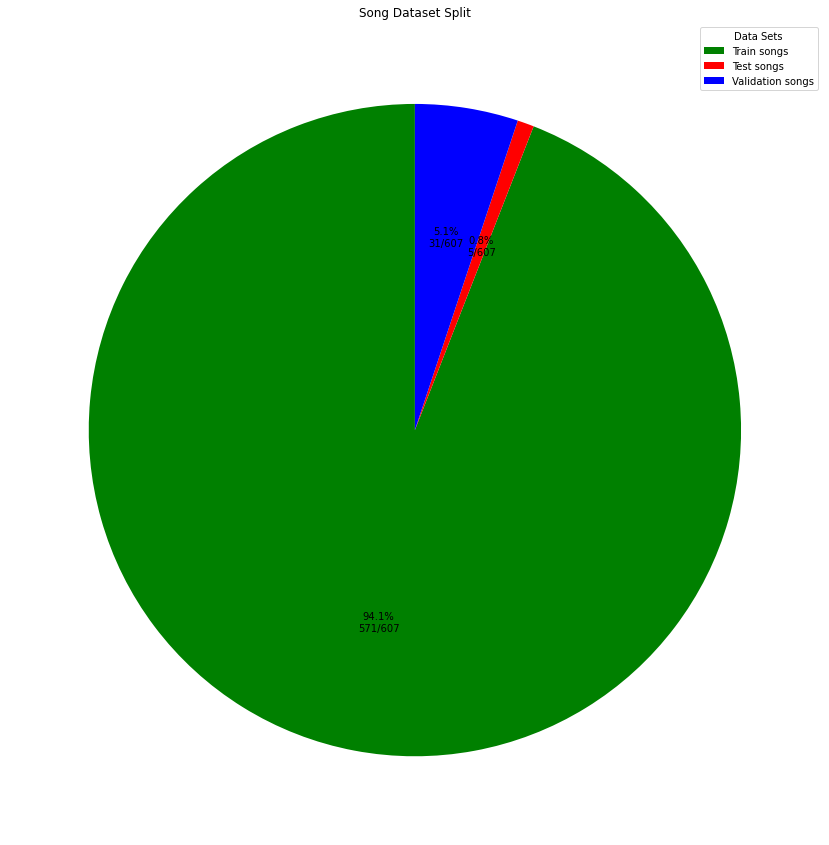

In [19]:
# Define pie chart labels
pie_labels = ["Train songs", "Test songs", "Validation songs"]

# Calculate the number of mismatch and match pairs in train set and test set
train_songs = len(train_df)
validation_songs = len(validation_df)
test_songs = len(test_df)
total = train_songs + test_songs + validation_songs

# Create data lists for train set and test set
data = [train_songs, test_songs, validation_songs]

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Create pie chart for train set
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: f"{pct:.1f}%\n{int(round(pct/100*total))}/{total}", startangle=90, colors = ["green", "red", "blue"])


# Add labels to pie wedges
for wedge, label in zip(wedges, pie_labels[:3]):
    wedge.set_label(f"{label}: {data[pie_labels.index(label)]}")


# Configure figure
ax.set_title("Song Dataset Split")

# Add legend
ax.legend(wedges, pie_labels, title="Data Sets")

# Show plot
plt.show()


#### Word-Cloud

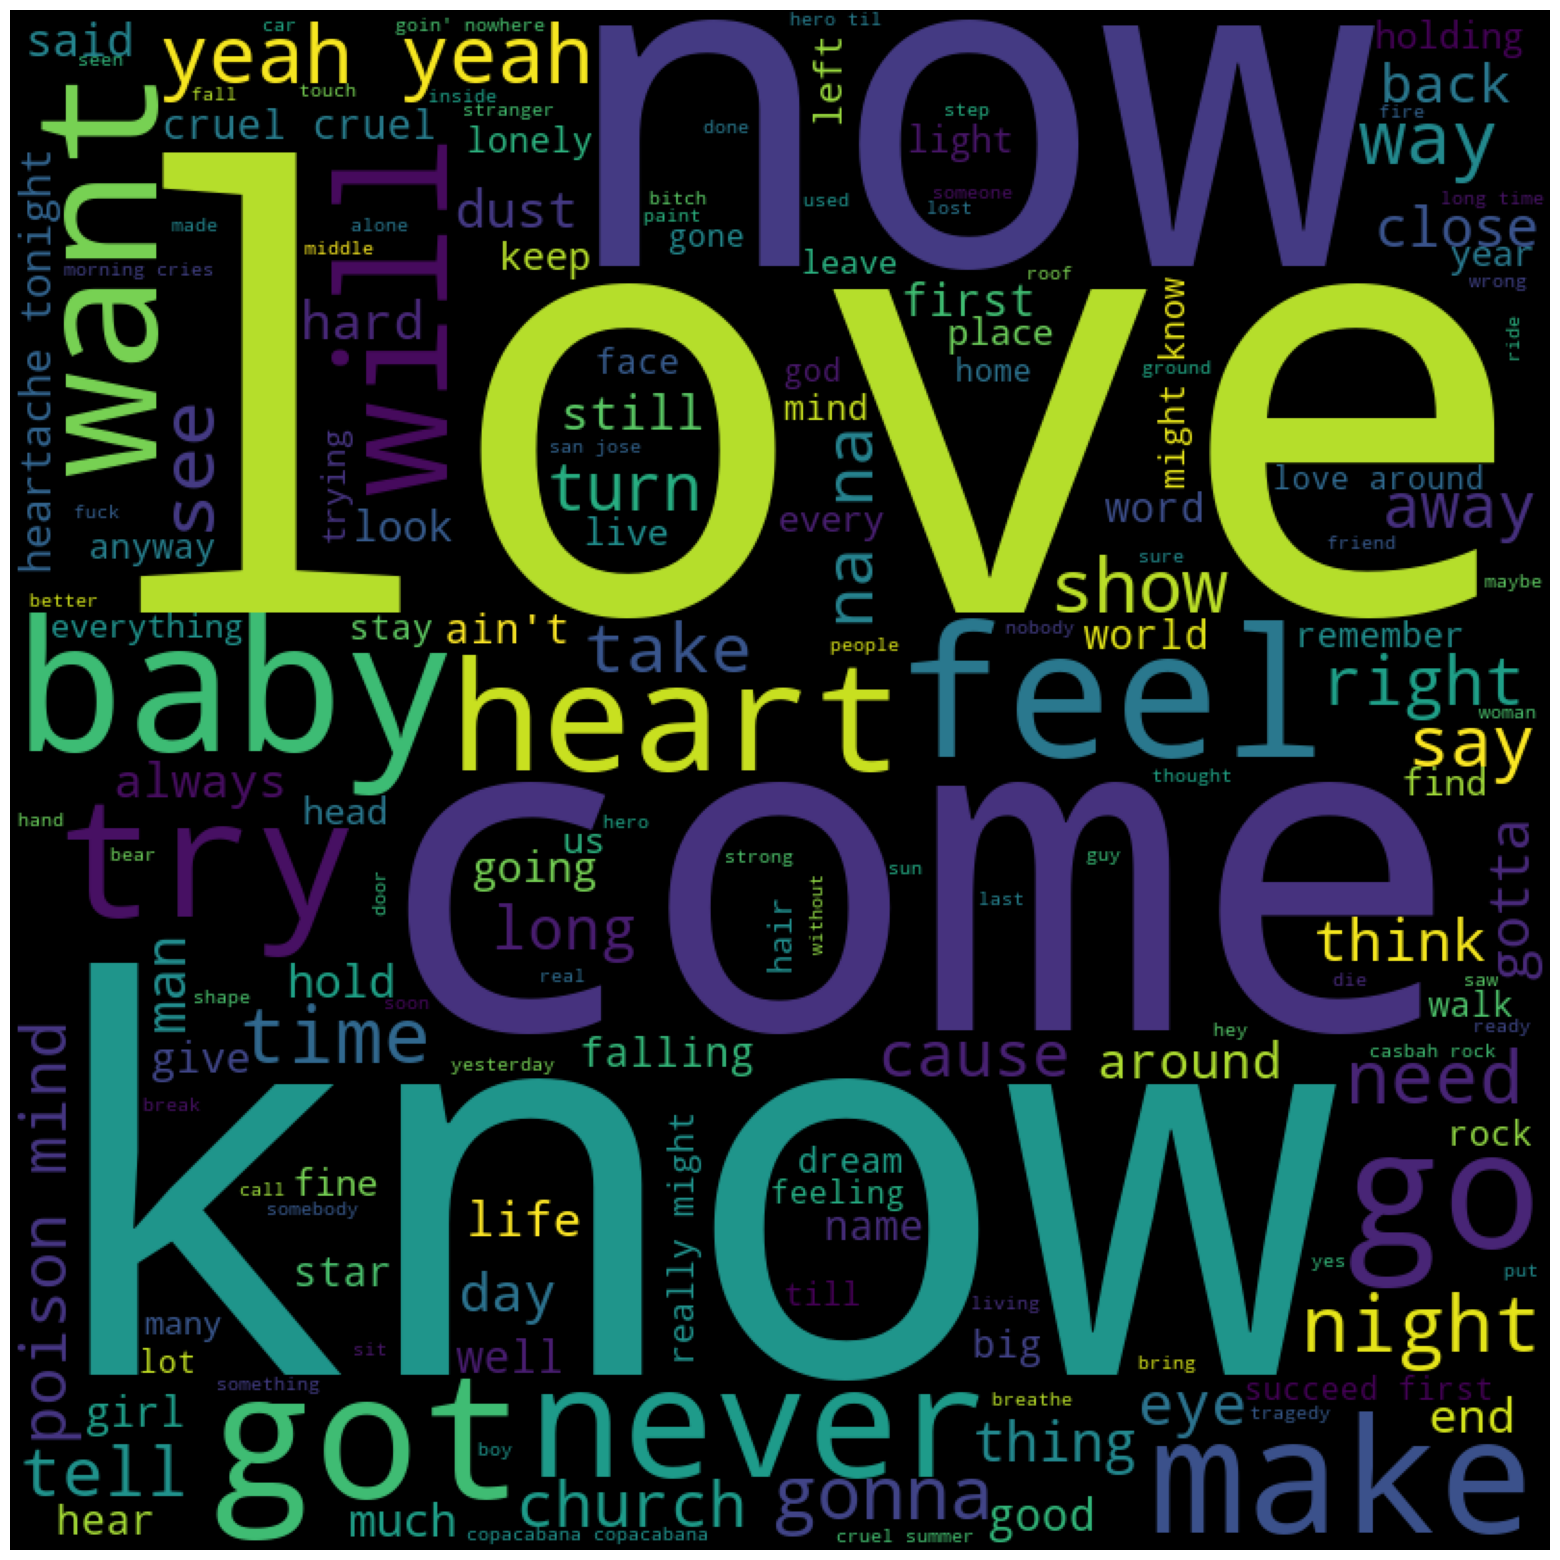

In [14]:
# Word Cloud

stopwords = set(STOPWORDS) | {"let", "one","oh", "la la", 'du'}
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(" ".join(
    lyrics for lyrics in train_df.lyrics))


plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Distribution of Words

/storage/modules/packages/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The song with the most relevant tokens (after filtering) is 'stan' of eminem with 1381 words.
The song with the least relevant tokens (after filtering) is 'sandstorm' of darude with 8 words.


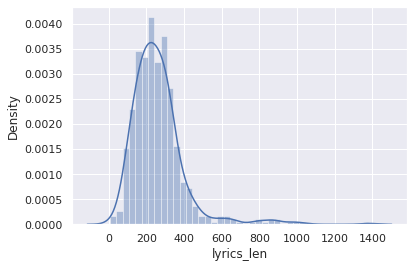

In [20]:

%matplotlib inline

sns.set()
train_df['lyrics_len'] = train_df['lyrics_tokens'].apply(lambda t: len(t))
sns.distplot(train_df['lyrics_len'])

# Find the song with the most words
song_most_words = train_df.loc[train_df['lyrics_len'].idxmax(), 'song']
song_most_words_artist = train_df.loc[train_df['lyrics_len'].idxmax(), 'artist']
most_words_count = train_df['lyrics_len'].max()

# Find the song with the least words
song_least_words = train_df.loc[train_df['lyrics_len'].idxmin(), 'song']
song_least_words_artist = train_df.loc[train_df['lyrics_len'].idxmin(), 'artist']
least_words_count = train_df['lyrics_len'].min()

print(f"The song with the most relevant tokens (after filtering) is '{song_most_words}' of {song_most_words_artist} with {most_words_count} words.")
print(f"The song with the least relevant tokens (after filtering) is '{song_least_words}' of {song_least_words_artist} with {least_words_count} words.")


The song with the most relevant tokens (after filtering) is 'barbie girl' of aqua with 395 words.
The song with the least relevant tokens (after filtering) is 'eternal flame' of the bangles with 95 words.


/storage/modules/packages/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


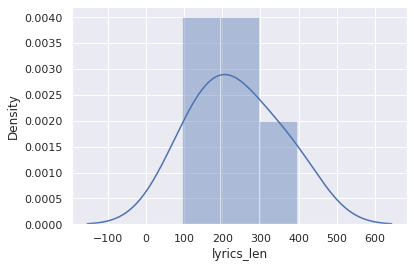

In [21]:

%matplotlib inline

sns.set()
test_df['lyrics_len'] = test_df['lyrics_tokens'].apply(lambda t: len(t))
sns.distplot(test_df['lyrics_len'])

# Find the song with the most words
song_most_words = test_df.loc[test_df['lyrics_len'].idxmax(), 'song']
song_most_words_artist = test_df.loc[test_df['lyrics_len'].idxmax(), 'artist']
most_words_count = test_df['lyrics_len'].max()

# Find the song with the least words
song_least_words = test_df.loc[test_df['lyrics_len'].idxmin(), 'song']
song_least_words_artist = test_df.loc[test_df['lyrics_len'].idxmin(), 'artist']
least_words_count = test_df['lyrics_len'].min()

print(f"The song with the most relevant tokens (after filtering) is '{song_most_words}' of {song_most_words_artist} with {most_words_count} words.")
print(f"The song with the least relevant tokens (after filtering) is '{song_least_words}' of {song_least_words_artist} with {least_words_count} words.")


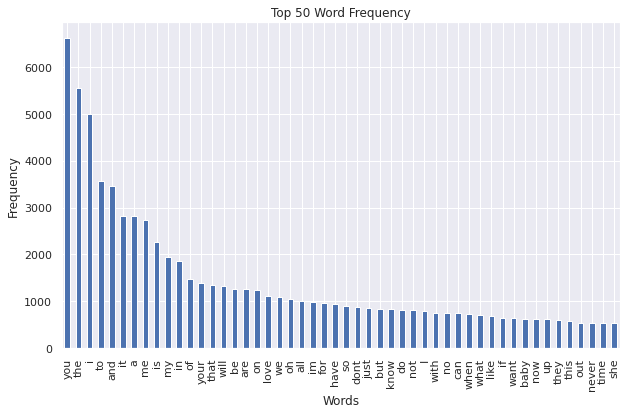

In [22]:

# Assuming you have a DataFrame named train_df with a 'lyrics' column

# Create a list of all the words in the lyrics
all_words = []
for i in list(train_df['lyrics_tokens']):
    for k in i:
        all_words.append(k)

# Calculate the frequency of each word
word_counts = pd.Series(all_words).value_counts()

# Select the top 50 words
top_50_words = word_counts[:50]

# Plot the word frequency for the top 50 words
plt.figure(figsize=(10, 6))
top_50_words.plot(kind='bar')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Word Frequency')
plt.show()


### 1.3. Word2Vec

In [23]:
# Word2Vec

# Create a list of all the words in the lyrics
list_of_lists_for_word2vec = []
for i in list(train_df['lyrics_tokens']):
    list_of_lists_for_word2vec.append(i)
for i in list(validation_df['lyrics_tokens']):
    list_of_lists_for_word2vec.append(i)
for i in list(test_df['lyrics_tokens']):
    list_of_lists_for_word2vec.append(i)
    
w2v_model = Word2Vec(list_of_lists_for_word2vec, min_count=1, vector_size=300, window=5)

all_words_in_corpus = w2v_model.wv.index_to_key
all_words_in_corpus_dict = w2v_model.wv.key_to_index
all_words_in_corpus_inverted_dict = {value: key for key, value in all_words_in_corpus_dict.items()}
all_words_in_corpus_size = len(all_words_in_corpus)

In [24]:
# word = 'love'  
# embedding = w2v_model.wv[word]  
# print(embedding)

In [25]:
def get_embeddings_column(tokenized_lyrics_data):
    """ 
    Retrieves word embeddings for each token in the tokenized lyrics data.

    Args:
        tokenized_lyrics_data (list): A list of tokenized lyrics data.

    Returns:
        numpy.ndarray: An array of word embeddings for each token in the tokenized lyrics data.
    
    """

    embeddings = []
    for lyrics in tokenized_lyrics_data:
        lyric_embeddings = []
        for word in lyrics:
            lyric_embeddings.append(w2v_model.wv[word])
        embeddings.append(np.array(lyric_embeddings))
    return np.array(embeddings, dtype=object)


In [26]:
train_df['word2vec_embeddings'] = get_embeddings_column(list(train_df['lyrics_tokens']))
validation_df['word2vec_embeddings'] = get_embeddings_column(list(validation_df['lyrics_tokens']))
test_df['word2vec_embeddings'] = get_embeddings_column(list(test_df['lyrics_tokens']))

### 1.4. Extraction of Midi Features

In [33]:
def get_min_max_midi_features(df):
    piano_max = float('-inf')
    piano_min = float('inf')

    total_velocity_max = float('-inf')
    total_velocity_min = float('inf')

    
    tempo_max = float('-inf')
    tempo_min = float('inf')


    tempo_changes_max = float('-inf')
    tempo_changes_min = float('inf')


    ints_total_notes_max = float('-inf')
    ints_total_notes_min = float('inf')


    ints_total_pitch_bends_max = float('-inf')
    ints_total_pitch_bends_min = float('inf')


    ints_total_control_changes_max = float('-inf')
    ints_total_control_changes_min = float('inf')

    for _, row in df.iterrows():
        mid = pretty_midi.PrettyMIDI(folder_path + "/" + row['midi_file'])
        total_velocity = sum(sum(mid.get_chroma()))
        tempo = mid.estimate_tempo()
        tempo_changes = mid.get_tempo_changes()[0].shape[0]
        piano = np.mean(mid.get_piano_roll(fs=1).flatten())
        

        #piano_roll_value_normalized = (np.mean(mid.get_piano_roll(fs=1).flatten()) - min_pianoRoll) / (max_pianoRoll - min_pianoRoll)
        ints_total_notes = 0
        ints_total_pitch_bends = 0
        ints_total_control_changes = 0
        for instrument in mid.instruments:
            if not instrument.is_drum:
                ints_total_notes += len(instrument.notes)
                ints_total_pitch_bends += len(instrument.pitch_bends)
                ints_total_control_changes += len(instrument.control_changes)

        # Update max_x and min_x
        if piano > piano_max:
            piano_max = piano
        if piano < piano_min:
            piano_min = piano

        
        # Update max_x and min_x
        if total_velocity > total_velocity_max:
            total_velocity_max = total_velocity
        if total_velocity < total_velocity_min:
            total_velocity_min = total_velocity

                # Update max_x and min_x
        if tempo > tempo_max:
            tempo_max = tempo
        if tempo < tempo_min:
            tempo_min = tempo

                # Update max_x and min_x
        if tempo_changes > tempo_changes_max:
            tempo_changes_max = tempo_changes
        if tempo_changes < tempo_changes_min:
            tempo_changes_min = tempo_changes

                # Update max_x and min_x
        if ints_total_notes > ints_total_notes_max:
            ints_total_notes_max = ints_total_notes
        if ints_total_notes < ints_total_notes_min:
            ints_total_notes_min = ints_total_notes
        
                # Update max_x and min_x
        if ints_total_pitch_bends > ints_total_pitch_bends_max:
            ints_total_pitch_bends_max = ints_total_pitch_bends
        if ints_total_pitch_bends < ints_total_pitch_bends_min:
            ints_total_pitch_bends_min = ints_total_pitch_bends

                # Update max_x and min_x
        if ints_total_control_changes > ints_total_control_changes_max:
            ints_total_control_changes_max = ints_total_control_changes
        if ints_total_control_changes < ints_total_control_changes_min:
            ints_total_control_changes_min = ints_total_control_changes
        
    return piano_max, piano_min, total_velocity_max, total_velocity_min, tempo_max, tempo_min, tempo_changes_max, tempo_changes_min, ints_total_notes_max, ints_total_notes_min, ints_total_pitch_bends_max, ints_total_pitch_bends_min, ints_total_control_changes_max, ints_total_control_changes_min
    

In [34]:
def extract_and_insert_into_df_general_midi_features(df):
    """
    Extracts general MIDI features from MIDI files and inserts them into the DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the 'midi_file' column.

    Returns:
        pandas.DataFrame: The modified DataFrame with additional columns for the extracted MIDI features.
    """

    # Initialize a new column 'midi_file_features_global' in the DataFrame with an empty array for each row
    df['midi_file_features_global'] = pd.Series([np.array([])] * len(df))

    # Retrieve the minimum and maximum values of MIDI features from the DataFrame
    piano_max, piano_min, total_velocity_max, total_velocity_min, tempo_max, tempo_min, tempo_changes_max, tempo_changes_min, ints_total_notes_max, ints_total_notes_min, ints_total_pitch_bends_max, ints_total_pitch_bends_min, ints_total_control_changes_max, ints_total_control_changes_min = get_min_max_midi_features(df)

    # Iterate over each row in the DataFrame
    for index, row in tqdm(df.iterrows()):
        # Load the MIDI file using the `pretty_midi.PrettyMIDI` class
        mid = pretty_midi.PrettyMIDI(folder_path + "/" + row['midi_file'])

        try:
            # Calculate and normalize various MIDI features
            total_velocity = (sum(sum(mid.get_chroma())) - total_velocity_min) / (total_velocity_max - total_velocity_min)
            tempo = (mid.estimate_tempo() - tempo_min) / (tempo_max - tempo_min)
            tempo_changes = (mid.get_tempo_changes()[0].shape[0] - tempo_changes_min) / (tempo_changes_max - tempo_changes_min)
            piano_roll_value = (np.mean(mid.get_piano_roll(fs=1).flatten()) - piano_min) / (piano_max - piano_min)

            # Calculate the count of various MIDI events
            ints_total_notes = 0
            ints_total_pitch_bends = 0
            ints_total_control_changes = 0
            for instrument in mid.instruments:
                if not instrument.is_drum:
                    ints_total_notes += len(instrument.notes)
                    ints_total_pitch_bends += len(instrument.pitch_bends)
                    ints_total_control_changes += len(instrument.control_changes)

            # Normalize the count of MIDI events
            ints_total_notes = (ints_total_notes - ints_total_notes_min) / (ints_total_notes_max - ints_total_notes_min)
            ints_total_pitch_bends = (ints_total_pitch_bends - ints_total_pitch_bends_min) / (ints_total_pitch_bends_max - ints_total_pitch_bends_min)
            ints_total_control_changes = (ints_total_control_changes - ints_total_control_changes_min) / (ints_total_control_changes_max - ints_total_control_changes_min)

            # Create an array of the calculated MIDI features
            features = np.array([tempo, tempo_changes, total_velocity, piano_roll_value, ints_total_notes, ints_total_pitch_bends, ints_total_control_changes])

        except Exception as e:
            # Handle any exceptions that occur during feature extraction
            print(e)
            features = np.array([])

        finally:
            # Update the 'midi_file_features_global' column of the DataFrame with the extracted features
            df.at[index, 'midi_file_features_global'] = features

    # Return the modified DataFrame with the additional MIDI feature column
    return df


In [35]:
test_df = extract_and_insert_into_df_general_midi_features(test_df)
validation_df = extract_and_insert_into_df_general_midi_features(validation_df)
train_df = extract_and_insert_into_df_general_midi_features(train_df)

5it [00:01,  3.61it/s]
/home/hersko/.local/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:104: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)
31it [00:10,  2.90it/s]
571it [03:18,  2.88it/s]


In [36]:
def extract_and_insert_into_df_per_word_midi_features(df):
    """
    Extracts per-word MIDI features from MIDI files and inserts them into the DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the 'midi_file' and 'lyrics_tokens' columns.

    Returns:
        pandas.DataFrame: The modified DataFrame with additional columns for the extracted per-word MIDI features.
    """

    # Initialize a new column 'midi_file_features_per_word' in the DataFrame with an empty array for each row
    df['midi_file_features_per_word'] = pd.Series([np.array([[np.array([])] * len(df['lyrics_tokens'])])] * len(df))

    # Iterate over each row in the DataFrame
    for index, row in tqdm(df.iterrows()):
        # Load the MIDI file using the `pretty_midi.PrettyMIDI` class
        mid = pretty_midi.PrettyMIDI(folder_path + "/" + row['midi_file'])
        
        # Remove invalid notes from the MIDI file
        mid.remove_invalid_notes()
        
        # Get the number of words in the song
        num_of_words_in_song = len(row['lyrics_tokens'])
        
        # Get the piano roll feature for all words in the song
        piano_feature_of_all_words = mid.get_piano_roll(fs=5)
        
        # Calculate the count of active notes for each time step
        counter = np.zeros(piano_feature_of_all_words.shape)
        for instrument in mid.instruments:
            counter[:, :instrument.get_piano_roll(fs=5).shape[1]] += (instrument.get_piano_roll(fs=5) > 0).astype(int)
        
        # Handle division by zero by setting zero elements to 1
        counter[counter == 0] = 1
        
        # Normalize the piano roll feature
        piano_feature_of_all_words /= counter
        piano_feature_of_all_words = piano_feature_of_all_words / 100
        
        # Calculate the count of relevant notes for each time step
        counter_of_all_relevant_notes = (piano_feature_of_all_words > 0).sum(axis=0)
        counter_of_all_relevant_notes[counter_of_all_relevant_notes == 0] = 1
        
        # Calculate the features for each word in the song
        curr_features = piano_feature_of_all_words.sum(axis=0) / counter_of_all_relevant_notes
        
        # Clean up the piano roll feature to remove unused elements
        del piano_feature_of_all_words
        
        # Create a contiguous array of current features
        arr = np.ascontiguousarray(curr_features[(curr_features > 0).argmax():])
        stride, = arr.strides
        
        # Create a sliding window view of the array to obtain features for each word in the song
        midi_feature_for_each_word_in_song = np.lib.index_tricks.as_strided(arr, (num_of_words_in_song, 4), (stride * (4 * 4) // 5, stride))
        
        # Handle special cases where features contain 'NaN' values
        midi_feature_for_each_word_in_song = np.vectorize(lambda x: float(str(x).split('e')[0]) if 'e' in str(x) else x)(midi_feature_for_each_word_in_song)
        midi_feature_for_each_word_in_song[np.isnan(midi_feature_for_each_word_in_song)] = 0.001
        
        # Update the 'midi_file_features_per_word' column of the DataFrame with the extracted features
        df.at[index, 'midi_file_features_per_word'] = midi_feature_for_each_word_in_song
    
   
    return df

In [37]:
test_df = extract_and_insert_into_df_per_word_midi_features(test_df)
train_df = extract_and_insert_into_df_per_word_midi_features(train_df)
validation_df = extract_and_insert_into_df_per_word_midi_features(validation_df)

5it [00:01,  4.41it/s]
571it [02:54,  3.28it/s]
31it [00:08,  3.47it/s]


## 2. Model 

### 2.1. Model - "Melody Per Song"

In [128]:
def split_df_to_X_y(df):
  X_embedding, X_melody, y = [],[], []
  word2vec_embeddings = df['word2vec_embeddings']
  midi_file_features_global = df['midi_file_features_global']
  for index_curr_embedding, curr_embedding in tqdm(enumerate(word2vec_embeddings)):
    for index_vec_of_word, vec_of_word in enumerate(curr_embedding):
      if index_vec_of_word < len(curr_embedding) - 1:
        X_embedding.append(np.array(vec_of_word))
        X_melody.append(np.array(midi_file_features_global.iloc[index_curr_embedding]))
        y_temp = np.zeros(all_words_in_corpus_size)
        lyric_token = df.iloc[index_curr_embedding]['lyrics_tokens']
        pred_word = lyric_token[index_vec_of_word + 1]
        y_temp[all_words_in_corpus_dict[pred_word]] = 1
        y.append(y_temp)
        
  X_embeddings_arr = np.array(X_embedding)
  X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0],1, X_embeddings_arr.shape[1])
  X_melody_arr = np.array(X_melody)
  X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])
  X = (X_embedding_reshape, X_melody_reshape)
  Y = np.array(y)


  return X, Y

In [129]:
train_df_X, train_df_Y = split_df_to_X_y(train_df)
validation_df_X, validation_df_Y = split_df_to_X_y(validation_df)
test_df_X, test_df_Y = split_df_to_X_y(test_df)

571it [00:41, 13.60it/s]
31it [00:02, 12.69it/s]
5it [00:00, 26.74it/s]


In [135]:
class LSTM_Model_Melody_Per_Song:
    def __init__(self, midi_features_vector_size=7, max_num_of_words=7485, dropout=0.2):
        input_midi_features = Input(shape=(1, midi_features_vector_size), name='input_midi_features')
        input_word_embedding = Input(shape=(1, 300), name='input_word_embedding')
        concatenation_of_input = Concatenate(axis=2, name='concatenation_of_input')([input_word_embedding, input_midi_features])

        layer = LSTM(32, return_sequences=True, dropout=dropout, name = 'first_layer_32')(concatenation_of_input)
        layer = LSTM(64, dropout=dropout, name = 'second_layer_64')(layer)
        layer = Dense(128, activation="relu", name='third_layer_128')(layer)
        layer = Dropout(dropout, name = 'dropout_layer')(layer)
        output = Dense(max_num_of_words, activation="softmax", name='output')(layer)

        self.model = Model([input_word_embedding, input_midi_features], output)
        

    def get_model(self):
        return self.model
    
    def train_model(self, train_df_X, train_df_Y, validation_df_X, validation_df_Y, batch_size = 64, loss='categorical_crossentropy', metric_arr=['MSE', 'CosineSimilarity'], learning_rate = 0.01, optimizer = optimizers.Adam, epoch = 50):
        
        curr_optimizer = optimizer(learning_rate)
        self.model.compile(loss=loss, metrics=metric_arr, optimizer= curr_optimizer)
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/sise/home/hersko/HW3_DL/model_per_song_tensorboard/", histogram_freq=1)
        earlystopping = callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose = 1, patience = 15)
        
        # fit the model to the data
        self.info = self.model.fit(x = train_df_X, y = train_df_Y, validation_data = [validation_df_X, validation_df_Y], batch_size = batch_size, epochs = epoch, callbacks=[tensorboard_callback, earlystopping])


    def predict_lyrics_for_single_song(self, single_song_df, num_of_words_to_predict = 50, word_to_begin=None):
        if word_to_begin == None:
            word_to_begin = single_song_df['lyrics_tokens'][0]

        generated_song = []
        for i in range(num_of_words_to_predict):
            generated_song.append(word_to_begin)
            word_embedding = w2v_model.wv[word_to_begin]

            X_embedding = []
            X_embedding.append(word_embedding)
            X_embeddings_arr = np.array(X_embedding)
            X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0],1, X_embeddings_arr.shape[1])
            
            X_melody = []
            X_melody.append(np.array(single_song_df['midi_file_features_global']))
            X_melody_arr = np.array(X_melody)
            X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])

            X = (X_embedding_reshape, X_melody_reshape)

            probs = self.model.predict(X)
            list_of_word_prob = np.asarray(probs).astype('float64')
            normalized_probs = list_of_word_prob[0] / np.sum(list_of_word_prob[0])
            word_encoding_index = np.random.choice(len(list_of_word_prob[0]), p=normalized_probs)
            word_to_begin = all_words_in_corpus_inverted_dict[word_encoding_index]

        
        s = single_song_df['lyrics']
        s_list = s.split(" & ")  # Split the string by '&'
        list_of_lists = [lst.split() for lst in s_list]  # Split each substring into a list of words
        len_list = [len(l) for l in list_of_lists]

        counter = 0
        internal_counter = 0
        s=""
        for line in len_list:
          while internal_counter!=line:
            s+=generated_song[counter]
            s+=" "
            counter+=1
            if counter==num_of_words_to_predict:
              break
            internal_counter+=1
          print(s)
          print("\n")
          s=""
          internal_counter = 0
          if counter==num_of_words_to_predict:
            break
        return ' '.join(generated_song)
    
    def show_model(self, path_name):
        print(self.model.summary())
        plot_model(self.model)
        plt.show()
        
        # show_history(self.info.history)
        # plot_history(self.info.history, path = path_name)
        plt.close()



    def evaluate(self, train_df_X, train_df_Y, test_df_X, test_df_Y):
        train_eval = self.model.evaluate(train_df_X, train_df_Y)
        test_eval = self.model.evaluate(test_df_X,test_df_Y)
        print(f"Evaluation on Train dataset - loss: {train_eval[0]}, MSE: {train_eval[1]}, cosine_similarity: {train_eval[2]}")
        print(f"Evaluation on Test dataset - loss: {test_eval[0]}, MSE: {test_eval[1]}, cosine_similarity: {test_eval[2]}")



In [136]:
model_melody_per_song = LSTM_Model_Melody_Per_Song(max_num_of_words = all_words_in_corpus_size)

In [137]:
model_melody_per_song.train_model(train_df_X, train_df_Y, validation_df_X, validation_df_Y, batch_size = 32, epoch=20)

Epoch 1/20
4650/4650 [==============================] - 86s 17ms/step - loss: 6.3372 - MSE: 1.3250e-04 - cosine_similarity: 0.0944 - val_loss: 6.7836 - val_MSE: 1.3267e-04 - val_cosine_similarity: 0.0859
Epoch 2/20
4650/4650 [==============================] - 77s 17ms/step - loss: 6.1872 - MSE: 1.3240e-04 - cosine_similarity: 0.0967 - val_loss: 6.8962 - val_MSE: 1.3265e-04 - val_cosine_similarity: 0.0868
Epoch 3/20
4650/4650 [==============================] - 77s 16ms/step - loss: 6.1645 - MSE: 1.3240e-04 - cosine_similarity: 0.0969 - val_loss: 6.9681 - val_MSE: 1.3264e-04 - val_cosine_similarity: 0.0873
Epoch 4/20
4650/4650 [==============================] - 78s 17ms/step - loss: 6.1559 - MSE: 1.3239e-04 - cosine_similarity: 0.0971 - val_loss: 7.0187 - val_MSE: 1.3268e-04 - val_cosine_similarity: 0.0863
Epoch 5/20
4650/4650 [==============================] - 77s 17ms/step - loss: 6.1655 - MSE: 1.3241e-04 - cosine_similarity: 0.0965 - val_loss: 7.0473 - val_MSE: 1.3266e-04 - val_cosine

In [133]:
model_melody_per_song.evaluate(train_df_X, train_df_Y, test_df_X, test_df_Y)

37/37 [==============================] - 0s 10ms/step - loss: 6.1647 - MSE: 1.3016e-04 - cosine_similarity: 0.1489
Evaluation on Train dataset - loss: 5.48635196685791, MSE: 0.00013061499339528382, cosine_similarity: 0.13605782389640808
Evaluation on Test dataset - loss: 6.164744853973389, MSE: 0.00013015730655752122, cosine_similarity: 0.148899644613266


In [3]:
model_melody_per_song.show_model('model_melody_per_song')


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_embedding (InputLay  [(None, 1, 300)]    0           []                               
 er)                                                                                              
                                                                                                  
 input_midi_features (InputLaye  [(None, 1, 7)]      0           []                               
 r)                                                                                               
                                                                                                  
 concatenation_of_input (Concat  (None, 1, 307)      0           ['input_word_embedding[0][0]',   
 enate)                                                           'input_midi_features[0][

### 2.2. Model - "Melody Per Word"

In [47]:
def split_df_to_X_y_per_word(df):
  X_embedding, X_melody, y = [],[], []
  word2vec_embeddings = df['word2vec_embeddings']
  midi_file_features_per_word = df['midi_file_features_per_word']
  for index_curr_embedding, curr_embedding in tqdm(enumerate(word2vec_embeddings)):
    for index_vec_of_word, vec_of_word in enumerate(curr_embedding):
      if index_vec_of_word < len(curr_embedding) - 1:
        if index_vec_of_word < midi_file_features_per_word.iloc[index_curr_embedding].shape[0]:
          X_embedding.append(np.array(vec_of_word))
          X_melody.append(np.array(midi_file_features_per_word.iloc[index_curr_embedding][index_vec_of_word]))
          y_temp = np.zeros(all_words_in_corpus_size)
          lyric_token = df.iloc[index_curr_embedding]['lyrics_tokens']
          pred_word = lyric_token[index_vec_of_word + 1]
          y_temp[all_words_in_corpus_dict[pred_word]] = 1
          y.append(y_temp)
        
  X_embeddings_arr = np.array(X_embedding)
  X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0],1, X_embeddings_arr.shape[1])
  X_melody_arr = np.array(X_melody)
  X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])
  X = (X_embedding_reshape, X_melody_reshape)
  Y = np.array(y)


  return X, Y

In [121]:
train_df_X, train_df_Y = split_df_to_X_y_per_word(train_df)
validation_df_X, validation_df_Y = split_df_to_X_y_per_word(validation_df)
test_df_X, test_df_Y = split_df_to_X_y_per_word(test_df)

571it [00:58,  9.83it/s]
31it [00:04,  6.29it/s]
5it [00:00, 26.52it/s]


In [123]:
class LSTM_Model_Melody_Per_Word:
    def __init__(self, midi_features_vector_size=4, max_num_of_words=7485, dropout=0.2):
        input_midi_features = Input(shape=(1, midi_features_vector_size), name='input_midi_features')
        input_word_embedding = Input(shape=(1, 300), name='input_word_embedding')
        concatenation_of_input = Concatenate(axis=2, name='concatenation_of_input')([input_word_embedding, input_midi_features])

        layer = LSTM(32, return_sequences=True, dropout=dropout, name = 'first_layer_32')(concatenation_of_input)
        layer = LSTM(64, dropout=dropout, name = 'second_layer_64')(layer)
        layer = Dense(128, activation="relu", name = 'third_layer_128')(layer)
        layer = Dropout(dropout, name = 'dropout_layer')(layer)
        output = Dense(max_num_of_words, activation="softmax", name='output')(layer)

        self.model = Model([input_word_embedding, input_midi_features], output)
        

    def get_model(self):
        return self.model
    
    def train_model(self, train_df_X, train_df_Y, validation_df_X, validation_df_Y, batch_size = 64, loss='categorical_crossentropy', metric_arr=['MSE', 'CosineSimilarity'], learning_rate = 0.01, optimizer = optimizers.Adam, epoch = 50):
        
        curr_optimizer = optimizer(learning_rate)
        self.model.compile(loss=loss, metrics=metric_arr, optimizer= curr_optimizer)
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/sise/home/hersko/HW3_DL/model_per_word_tensorboard/", histogram_freq=1)
        # Create Callback for model early stopping
        earlystopping = callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose = 1, patience = 15)
        
        # fit the model to the data
        self.info = self.model.fit(x = train_df_X, y = train_df_Y, validation_data = [validation_df_X, validation_df_Y], batch_size = batch_size, epochs = epoch, callbacks=[tensorboard_callback, earlystopping])
    


    def predict_lyrics_for_single_song(self, single_song_df, num_of_words_to_predict = 50, word_to_begin=None):
        if word_to_begin == None:
            word_to_begin = single_song_df['lyrics_tokens'][0]

        generated_song = []
        for i in range(num_of_words_to_predict):
            generated_song.append(word_to_begin)
            word_embedding = w2v_model.wv[word_to_begin]

            X_embedding = []
            X_embedding.append(word_embedding)
            X_embeddings_arr = np.array(X_embedding)
            X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0],1, X_embeddings_arr.shape[1])
            
            X_melody = []
            X_melody.append(np.array(single_song_df['midi_file_features_per_word'])[i])
            X_melody_arr = np.array(X_melody)
            X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])

            X = (X_embedding_reshape, X_melody_reshape)

            probs = self.model.predict(X)
            list_of_word_prob = np.asarray(probs).astype('float64')
            normalized_probs = list_of_word_prob[0] / np.sum(list_of_word_prob[0])
            word_encoding_index = np.random.choice(len(list_of_word_prob[0]), p=normalized_probs)
            word_to_begin = all_words_in_corpus_inverted_dict[word_encoding_index]

        
        s = single_song_df['lyrics']
        s_list = s.split(" & ")  # Split the string by '&'
        list_of_lists = [lst.split() for lst in s_list]  # Split each substring into a list of words
        len_list = [len(l) for l in list_of_lists]

        counter = 0
        internal_counter = 0
        s=""
        for line in len_list:
          while internal_counter!=line:
            s+=generated_song[counter]
            s+=" "
            counter+=1
            if counter==num_of_words_to_predict:
              break
            internal_counter+=1
          print(s)
          print("\n")
          s=""
          internal_counter = 0
          if counter==num_of_words_to_predict:
            break
        return ' '.join(generated_song)
    
    def show_model(self, path_name):
        print(self.model.summary())
        plot_model(self.model)
        plt.show()
        
        # show_history(self.info.history)
        # plot_history(self.info.history, path = path_name)
        plt.close()



    def evaluate(self, train_df_X, train_df_Y, test_df_X, test_df_Y):
        train_eval = self.model.evaluate(train_df_X, train_df_Y)
        test_eval = self.model.evaluate(test_df_X,test_df_Y)
        print(f"Evaluation on Train dataset - loss: {train_eval[0]}, MSE: {train_eval[1]}, cosine_similarity: {train_eval[2]}")
        print(f"Evaluation on Test dataset - loss: {test_eval[0]}, MSE: {test_eval[1]}, cosine_similarity: {test_eval[2]}")



In [124]:
model_melody_per_word = LSTM_Model_Melody_Per_Word(max_num_of_words = all_words_in_corpus_size)

In [125]:
model_melody_per_word.train_model(train_df_X, train_df_Y, validation_df_X, validation_df_Y, batch_size = 32, epoch=20)

Epoch 1/20
4650/4650 [==============================] - 89s 17ms/step - loss: 6.1772 - MSE: 1.3222e-04 - cosine_similarity: 0.1030 - val_loss: 6.6944 - val_MSE: 1.3231e-04 - val_cosine_similarity: 0.0974
Epoch 2/20
4650/4650 [==============================] - 75s 16ms/step - loss: 5.9599 - MSE: 1.3184e-04 - cosine_similarity: 0.1115 - val_loss: 6.7567 - val_MSE: 1.3189e-04 - val_cosine_similarity: 0.1036
Epoch 3/20
4650/4650 [==============================] - 74s 16ms/step - loss: 5.8893 - MSE: 1.3169e-04 - cosine_similarity: 0.1137 - val_loss: 6.8018 - val_MSE: 1.3189e-04 - val_cosine_similarity: 0.1058
Epoch 4/20
4650/4650 [==============================] - 75s 16ms/step - loss: 5.8449 - MSE: 1.3161e-04 - cosine_similarity: 0.1161 - val_loss: 6.8653 - val_MSE: 1.3171e-04 - val_cosine_similarity: 0.1103
Epoch 5/20
4650/4650 [==============================] - 75s 16ms/step - loss: 5.8209 - MSE: 1.3154e-04 - cosine_similarity: 0.1177 - val_loss: 6.8513 - val_MSE: 1.3175e-04 - val_cosine

In [127]:
model_melody_per_word.evaluate(train_df_X, train_df_Y, test_df_X, test_df_Y)

37/37 [==============================] - 0s 12ms/step - loss: 6.3166 - MSE: 1.3062e-04 - cosine_similarity: 0.1387
Evaluation on Train dataset - loss: 5.582456111907959, MSE: 0.0001308914797846228, cosine_similarity: 0.12938562035560608
Evaluation on Test dataset - loss: 6.316600322723389, MSE: 0.0001306244230363518, cosine_similarity: 0.13867446780204773


In [2]:
model_melody_per_word.show_model('model_melody_per_word')


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lyrics (InputLayer)            [(None, 1, 300)]     0           []                               
                                                                                                  
 melody (InputLayer)            [(None, 1, 4)]       0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 1, 304)       0           ['lyrics[0][0]',                 
                                                                  'melody[0][0]']                 
                                                                                                  
 lstm_6 (LSTM)                  (None, 1, 64)        94464       ['concatenate[0][0]']     

### 2.3. Tensorboard

In [ ]:
tensorboard --logdir="C:\Users\Administrator\VsProjects\Deep_Learning\HW3\model_per_word_tensorboard"

In [ ]:
tensorboard --logdir="C:\Users\Administrator\VsProjects\Deep_Learning\HW3\model_per_song_tensorboard_2"

### 2.4. Prediction on Test set

In [142]:
models_name = ["model_melody_per_song", "model_melody_per_word"]
models = [model_melody_per_song, model_melody_per_word]
words_run = ['original_word','you', 'the','love']
number_of_words_to_predict = 50

In [1]:
for _, song in test_df.iterrows():
    for index, model in enumerate(models):
        for word in words_run:
            if word == 'original_word':
                word = song['lyrics_tokens'][0]
            print(f"----------model : {models_name[index]}----------song : {song['song']}----------first word : {word}")
            model.predict_lyrics_for_single_song(song, num_of_words_to_predict = number_of_words_to_predict, word_to_begin=word)

 

----------model : model_melody_per_song----------song : eternal flame----------first word : close

close wait time treat will I what hear 


for guitar shit wicked dont know 


you and with 


true sky my faith and 


and should be am 


past too are gentle someday a 


of on getting the on interstate finally 


on town her of you boy mind 


a too will I 


----------model : model_melody_per_song----------song : eternal flame----------first word : you

you when want they can just look yippe 


knew wear see reason you I 


more are i 


it your the my have 


what destroy come find 


through me on i dollar and 


big did is you at sail break 


out love your will she I could 


us i the the 


----------model : model_melody_per_song----------song : eternal flame----------first word : the

the what not snow are now this my 


the my need hit before needs 


then find by 


midnight i know in is 


secret cold whether my 


to ours face you not meet 


lose a the knew now they to 

